# Introduction

Brain age prediction consists in training a machine learning model to predict an individual's age from brain MRI data. It has been widely investigated in recent years ([survey about brain age prediction](https://link-springer-com.ressources-electroniques.univ-lille.fr/article/10.1007/s10916-019-1401-7)).

In this practical, we will use MRI data from healthy subjects to train and evaluate machine learning models for brain age prediction. The data consist of cortical thickness measures extracted from MR images with [an automated parcellation tool](https://surfer.nmr.mgh.harvard.edu/fswiki/CorticalParcellation).

The data are compiled into the **data.csv** file. Each line is associated to an MR image and gives the following information:
  - `entry_id`: unique identifier
  - `sub_id`: subject identifier (some subjects have been scanned several times)
  - `site`: name of the site where the image has been acquired
  - `sex`
  - `age`
  - the cortical thickness measures in milimeter:
    - measures of the left brain hemisphere (the column names starting with *lh_*)
    - measures of the right brain hemisphere (the column names starting with *rh_*)

# Exploration of the metadata

## Global information

Load the file into a *pandas.DataFrame* and print the following information:
  - the total number of MR images
  - the total number of subjects
  - the number of cortical thickness measures

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pylab as plt 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.base import BaseEstimator
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
df = pd.read_csv('data_practical2.csv')

In [3]:
print(f'total number of MR image', df.shape[0])
print(f'total number of subjects', df['sub_id'].nunique())
print(f'total number of cortical thickness', df.shape[1]-5)

total number of MR image 3356
total number of subjects 2662
total number of cortical thickness 148


## Statistics per site

Print the number of MR images and the number of subjects within each site.

In [4]:
df.groupby('site').size()

site
CI2C        18
COBRE      238
CODE2       23
CPP         19
FBIRN      249
Guys       314
HCP       1112
HH         181
IOP         68
MCIC       261
NKI        734
NMORPH     139
dtype: int64

In [5]:
df.groupby('site').aggregate({'sub_id':'nunique'})

,sub_id
site,
CI2C,5
COBRE,94
CODE2,23
CPP,19
FBIRN,94
Guys,314
HCP,1112
HH,181
IOP,68


## Age distributions

Display two figures: the first one contains a **count histogram** of the global age distribution and the second one contains one **probability histogram** of age distribution for each site. For the latter, the probabilities must be computed independently for each site.

Use the following histogram bins: `range(5,95,5)`.

*seaborn.histplot* may be helpful.

In [6]:
import seaborn as sns

In [7]:
bins = range(5,95,5)

<AxesSubplot:xlabel='age', ylabel='Count'>

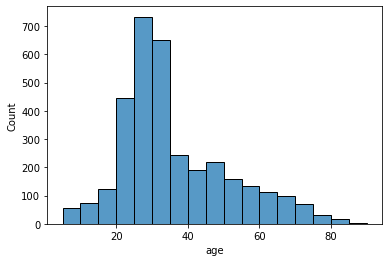

In [8]:
sns.histplot(data= df, x= df['age'], bins=bins, legend = 'True' )

<AxesSubplot:xlabel='age', ylabel='Probability'>

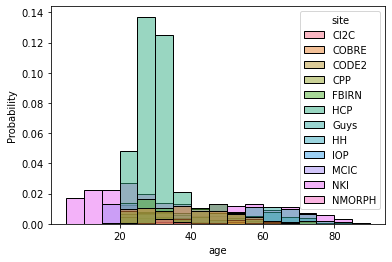

In [9]:
sns.histplot(data= df, x= df['age'], bins=bins, hue='site',legend = 'True', stat='probability' )

# Univariate analysis

We will first investigate the relation between age and cortical thickness. It is known that cortical thickness decreases with aging, in a constant way throughout adulthood.

For each MR image, compute the median over the cortical thickness measures. Then display a scatter plot of this median as a function of age. Add to the figure a regression line (linear least-squares regression) and print the Pearson correlation coefficient. Generally, what does this coefficient quantify ?

<AxesSubplot:xlabel='age'>

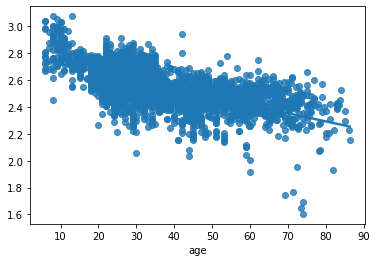

In [10]:
# Rmimage_first = df.iloc[0][5:]
Rmimage_median=[]
for line in range(len(df)):
    Rmimage_median.append(df.iloc[line][5:].median())
sns.regplot(data=df, x='age',y=Rmimage_median)

In [11]:
print('correlation coefficients are :')
np.corrcoef(x=df['age'],y=Rmimage_median)

correlation coefficients are :


array([[ 1.        , -0.63213242],
       [-0.63213242,  1.        ]])

what does this coefficient quantify ?
The correlation coefficient shows the correlation between the age and cortical thickness. We can see clearly from the figure that when the age of an individual increase, the cortical thickness decrease.

# Machine learning

In this section, we will use the *sklearn* module for machine learning in order to predict age from the cortical thickness measures. Use the *random_state* parameter when possible to make your results reproducible across runs.

## Train/test splitting

Start by dividing your MR images into a training and a test set. As seen earlier, some subjects have several images in the dataset; prevent the presence of subjects in both the training and the test sets. Keep 20% of the subjects for the test.

In [12]:
mr_train_test= df.drop_duplicates(subset=['sub_id'])
train_mr, test_mr = train_test_split(mr_train_test, test_size=0.2)

Compute the mean and the standard deviation of age in the training and test set respectively to check that the age distributions are similar between both sets (less than 3 years of difference).

In [13]:
print(f"the mean of the age in the training set : {train_mr['age'].mean():.3f}")
print(f"the standard deviation of the age in the training set  : {train_mr['age'].std():.3f}")

the mean of the age in the training set : 36.524
the standard deviation of the age in the training set  : 15.782


State the following nummpy arrays:
  - `X_train`: cortical thicknesses of the training set -> shape (n_train,n_features)
  - `X_test`: cortical thicknesses of the test test -> shape (n_test,n_features)
  - `Y_train`: the ages in the training set -> shape (n_train,)
  - `Y_test`: the ages in the test set -> shape (n_test,)

In [14]:
X =df.drop(columns= ['entry_id','site','sub_id','sex','age'])
y= df['age']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=42)

In [15]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2684, 148), (672, 148), (2684,), (672,))

## Training/evaluation of different models

### Univariate linear regression

We previously studied the relation between age and the median cortical thickness. We will continue in this voice and try to predict an individual's age from its median cortical cortical thickness. To enable non-linearity, we will use the [sklearn PolynomialFeatures class](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html) as a preprocessing step (i.e. input $(x,)$ become $(x,x^2,...,x^{d\_max})$).

#### Defining the model

Define a sklearn predictor that performs the following steps:
  1. Compute the median for each entry
  2. Generate polynomial features from the median for each entry (the maximal degree is an hyperparameter).
  3. Perform an ordinary least squares linear regression from these features.
  
Note: In order to create a sklearn predictor, you can read [this](https://scikit-learn.org/stable/developers/develop.html). You can use the below code skeleton.

In [15]:
class AgePredictor_polyReg(BaseEstimator):
    
    def __init__(self, degree=1):
        self.degree = degree
        
    def fit(self, X, y):
        self.medians_ = np.median(X, axis=1).reshape(-1, 1)
        self.polynomial_features_ = PolynomialFeatures(degree=self.degree)
        X_median_poly = self.polynomial_features_.fit_transform(self.medians_)
        self.lg_ = LinearRegression()
        self.lg_.fit(X_median_poly, y)
        return self
    
    def predict(self, X):
        medians = np.median(X, axis=1).reshape(-1, 1)
        X_median_poly = self.polynomial_features_.transform(medians)
        return self.lg_.predict(X_median_poly)
    
    def score(self,X,y):
        y_pred = self.predict(X)
        return mean_absolute_error(y, y_pred)

#### Training with hyperparameter optimisation

Apply a grid search cross validation on the training set to optimise the hyperparameter of the model (i.e. the maximal degree of the generated polynoms). You can use a range from 1 to 5 for the search. Use the mean absolute error (MAE) as the grid search loss. *sklearn.model_selection.GridSearchCV* may be useful.

In [16]:
from sklearn.model_selection import GridSearchCV
param = {'degree': [1,2,3,4,5]}
ml = AgePredictor_polyReg()
clf = GridSearchCV(ml, param, scoring='neg_mean_absolute_error',return_train_score=True)
clf.fit(X_train,y_train)
clf.best_params_

{'degree': 5}

In [17]:
clf.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_degree', 'params', 'split0_test_score', 'split1_test_score', 'split2_test_score', 'split3_test_score', 'split4_test_score', 'mean_test_score', 'std_test_score', 'rank_test_score', 'split0_train_score', 'split1_train_score', 'split2_train_score', 'split3_train_score', 'split4_train_score', 'mean_train_score', 'std_train_score'])

In [18]:
clf.cv_results_['mean_test_score']

array([-9.19570284, -9.22927458, -9.14444779, -9.17935866, -9.12609773])

In [19]:
clf.cv_results_['mean_train_score']

array([-9.18499159, -9.21777093, -9.12720331, -9.15538378, -9.08784474])

Based on the results of the grid search, display in a scatter plot the train and the validation MAE as a function of the maximal degree of the polynom. Comment briefly the results.

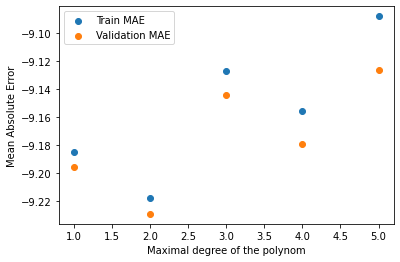

In [20]:
import matplotlib.pyplot as plt

degrees = param['degree']
train_scores = clf.cv_results_['mean_train_score']
test_scores = clf.cv_results_['mean_test_score']

plt.scatter(degrees, train_scores, label='Train MAE')
plt.scatter(degrees, test_scores, label='Validation MAE')
plt.xlabel('Maximal degree of the polynom')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.show()

#### Evaluation on the test set

Apply the model resulting from the grid search to the test set and print the MAE.

In [21]:
ag = AgePredictor_polyReg(degree=5)
ag.fit(X_train,y_train)

print(f"the mean absolute error resulting form the grid search : {np.abs(ag.predict(X_test)-y_test).mean():.3f}")

the mean absolute error resulting form the grid search : 8.597


### Ridge regression

The previous predictor was univariate as it was limited to 1 input feature. We will now exploit all the cortical thickness features with Ridge regression. Ridge regression is a linear least squares regression with an l2 regularization on the regression coefficients. It includes an hyperparameter weighting the l2 penalty.

#### Defining the model

Should we standardize our features (i.e. cortical thickness measures) before applying a Ridge regression ? **Argue** and define your model according to your choice. 

Standardizing the features, also known as feature scaling, can be beneficial when applying Ridge regression or any other regularized linear regression model. The reason is that Ridge regression and other regularized linear regression models use the L2 norm, also known as the Euclidean norm, of the coefficients as a regularization term. This means that the magnitude of the coefficients affects the regularization term, and if the features have different scales, the regularization term will be affected by the scale of the features.

When the features have different scales, the features with larger scales will have a bigger impact on the regularization term, and this can cause the model to prefer those features over the others. Standardizing the features, i.e. scaling them to have zero mean and unit variance, can help to prevent this bias. This is because it will make all the features have the same scale, so they will all have the same impact on the regularization term.

It's worth noting that standardizing the features is not always necessary, but it can help to improve the performance of Ridge regression and other regularized linear regression models when the features have different scales.

In summary, yes, it is a good practice to standardize the features before applying a Ridge Regression.

#### Training with hyperparameter optimization

Train your model on the training set with a grid search cross validation for optimizing the hyperparameter related to the l2 regularization. Then plot the resulting train and validation MAE as a function of this hyperparameter.

In [42]:
from sklearn.linear_model import Ridge
alpha_range = np.arange(0.01, 10.1, 0.1)
ridge = Ridge(alpha=1.0)
grid_search = GridSearchCV(ridge, param_grid={'alpha': alpha_range}, cv=5,return_train_score=True)
grid_search.fit(X_train, y_train)
grid_search.best_params_, grid_search.best_score_

({'alpha': 8.41}, 0.6681473417800298)

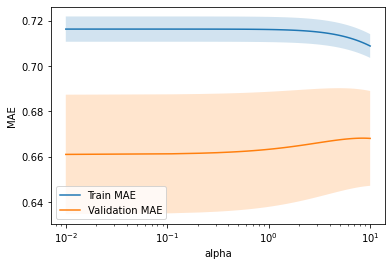

In [43]:

# Extract the mean and std of the MAE for each value of alpha
mean_train_mae = grid_search.cv_results_['mean_train_score']
std_train_mae = grid_search.cv_results_['std_train_score']
mean_val_mae = grid_search.cv_results_['mean_test_score']
std_val_mae = grid_search.cv_results_['std_test_score']

# Plot the train and validation MAE as a function of alpha
plt.plot(alpha_range, mean_train_mae, label='Train MAE')
plt.fill_between(alpha_range, mean_train_mae-std_train_mae, mean_train_mae+std_train_mae, alpha=0.2)
plt.plot(alpha_range, mean_val_mae, label='Validation MAE')
plt.fill_between(alpha_range, mean_val_mae-std_val_mae, mean_val_mae+std_val_mae, alpha=0.2)
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('MAE')
plt.legend()
plt.show()

This plot will show the trade-off between the model's complexity and performance, we can use this graph to select the best value for the alpha hyperparameter. <br>
In this case, the standard deviation of the validation mae is too large. This means, that the model performance is unstable. This could mean that the model is overfitting or underfiting or that the data is too noisy

#### Evaluation on the test set

Apply the model resulting from the grid search to the test set and print the MAE.

In [59]:
from sklearn.metrics import mean_absolute_error

# Get the best model from the grid search
best_model_ridge = grid_search.best_estimator_

# Make predictions on the test set
y_pred_ridge = best_model_ridge.predict(X_test)

# Calculate the MAE
mae = mean_absolute_error(y_test, y_pred_ridge)
print(f'Test MAE: {mae:.3f}')


Test MAE: 6.874


### Support vector regression

We will now experiment a kernel method that enables the learning of non-linear functions: Support Vector Regression (SVR).

#### Defining the model

The kernel methods are based on similarity functions. They therefore require a prior feature standardization.

Define a sklearn model performing the standardization and the SVR. You can use [sklearn pipelines](https://scikit-learn.org/stable/modules/compose.html#pipeline). We will use the following settings for the SVR (see the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)):
  - `kernel`: radial basis function to enable non-linearity
  - `C`: hyperparameter of our model (optimized latter)
  - `epsilon`: hyperparameter of our model (optimized latter)

In [45]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

# Define the pipeline
pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('svr', SVR())
])

# Fit the pipeline to the data
pipe.fit(X_train, y_train)


Pipeline(steps=[('scaler', StandardScaler()), ('svr', SVR())])

#### Training with hyperparameter optimization

We will perform a grid search cross-validation in order to optimize two SVR hyperparameters: `C` and `epsilon`. These are two regularization hyperparameters. Based on the sklearn documentation, is the regularization stronger with the increase of `C` ? Same question for `epsilon`. 

A lower value of C corresponds to stronger regularization, while a higher value of C corresponds to weaker regularization. In other words, increasing the value of C decreases the regularization strength, making the decision boundary less smooth, allowing more flexibility in the model and increasing the risk of overfitting. <br>
A higher value of epsilon corresponds to a larger margin of tolerance and therefore weaker regularization. This means that the model will be more permissive in allowing errors in the predictions, allowing for more flexibility in the model and increasing the risk of overfitting.On the other hand, a lower value of epsilon corresponds to a smaller margin of tolerance and therefore stronger regularization. This means that the model will be less permissive in allowing errors in the predictions, leading to a more robust model with less overfitting.

Train your model on the training set with a grid search cross-validation for optimizing these two hyperparameters. Then plot the resulting train and validation MAE as a function of the two hyperparameters. Note: you can use the matplotlib imshow function to plot heatmaps.

In [46]:
param_grid = dict(svr__C=np.arange(1,5,1),svr__epsilon=np.arange(0.1, 10,1))
grids = GridSearchCV(pipe, param_grid=param_grid,cv=5,return_train_score=True)
grids.fit(X_train, y_train)
grids.best_params_, grids.best_score_

({'svr__C': 4, 'svr__epsilon': 1.1}, 0.6825196885752786)

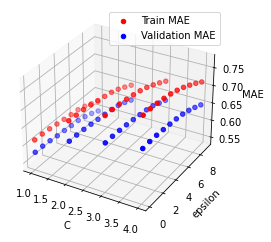

In [47]:
# Extract the values of C and epsilon from the grid search results
c_values = grids.cv_results_['param_svr__C']
epsilon_values = grids.cv_results_['param_svr__epsilon']

# Extract the train and validation MAE from the grid search results
train_scores = grids.cv_results_['mean_train_score']
valid_scores = grids.cv_results_['mean_test_score']

# Plot the train and validation MAE as a function of C and epsilon
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(c_values, epsilon_values, train_scores, c='r', label='Train MAE')
ax.scatter(c_values, epsilon_values, valid_scores, c='b', label='Validation MAE')
ax.set_xlabel('C')
ax.set_ylabel('epsilon')
ax.set_zlabel('MAE')
plt.legend()
plt.show()


#### Evaluation on the test set

Apply the model resulting from the grid search to the test set and print the MAE.

In [60]:
from sklearn.metrics import mean_absolute_error

# Get the best model from the grid search
best_model_svr = grids.best_estimator_

# Make predictions on the test set
y_pred_svr = best_model_svr.predict(X_test)

# Calculate the MAE
mae = mean_absolute_error(y_test, y_pred_svr)
print(f'Test MAE: {mae:.3f}')


Test MAE: 5.956


### Gaussian process regression

Gaussian process regression (GPR) is another kernel method based on Bayesian inference. One interesting property is that GPRs often don't require a thorough hyperparameter optimizations.

#### Defining the model

Define a sklearn model performing the standardization and the GPR. For the GPR, you can use the default sklearn hyperparameters, except for the kernel that can be set to RBF without fixed length scale (length scale will thus be optimized heuristically during training).

In [49]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = RBF()
# Define the pipeline
pipe = Pipeline([('scaler', StandardScaler()), ('gpr', GaussianProcessRegressor(kernel=kernel))])


#### Training

Train the GPR on the training set.

In [50]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('gpr', GaussianProcessRegressor(kernel=RBF(length_scale=1)))])

#### Evaluation on the test set

Apply the model to the test set and print the MAE.

In [51]:
ypred_gpr = pipe.predict(X_test)
print(f"mean absolute error is : {mean_absolute_error(y_test,ypred_gpr): .3f}")

mean absolute error is :  6.469


### Summary

Among the 4 models you tested, which one gave the best performance ? What was the corresponding MAE ?

## Ensemble Learning

In machine learning, ensemble learning methods use several algorithms for the purpose of improving the predictions. Here, we will perform ensemble learning from the 4 models we previously defined.

### Average prediction

A simple way to combine our models is to average the predictions of the 4 models. Try this technique by predicting the ages of the test set with the models you previously trained on the training set. Then print the corresponding MAE.

In [61]:
y_pred_polReg=ag.predict(X_test) #using univariate linear regression
y_pred_ridge = best_model_ridge.predict(X_test) #using ridge model 
y_pred_svr = best_model_svr.predict(X_test) #using svr model 
ypred_gpr = pipe.predict(X_test) # using gpr model

# Average the predictions
y_pred_avg = (y_pred_polReg + y_pred_ridge + y_pred_svr + ypred_gpr) / 4
print(f'the average prediction of the 4 models: {mean_absolute_error(y_test,y_pred_avg):.3f}')

the average prediction of the 4 models: 6.107


Comment the result.

### Learning from predictions

A more sophisticated approach consists in training a new machine learning model to make predictions from the predictions of the different models we want to combine.

#### Preparation of the training set

As such a model is trained based on predictions, we first need to build a new training set by predicting age associated with each MR image of the training set for each of the 4 models.

Create such a variable `X_train2` of shape (n_train,4) by doing cross-validate estimations ([sklearn method](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html)). You can reuse the hyperparameters you previously estimated with grid seach cross-validation.

In [63]:
from sklearn.model_selection import cross_val_predict



# Get cross-validated predictions for each model
y_pred_polReg = cross_val_predict(clf, X_train, y_train, cv=5)
y_pred_ridge = cross_val_predict(best_model_ridge, X_train, y_train, cv=5)
y_pred_svr = cross_val_predict(best_model_svr, X_train, y_train, cv=5)
ypred_gpr = cross_val_predict(pipe, X_train, y_train, cv=5)

# Combine the predictions into a single array
X_train2 = np.column_stack((y_pred_polReg, y_pred_ridge, y_pred_svr, ypred_gpr))

# Print the shape of the new training data
print(X_train2.shape)


(2684, 4)


#### Predictions with Random Forest

Now we have a training set with predictions of our different models, we will train a Random Forest to predict age from them. Are our 4 training features highly correlated here ? Is Random Forest appropriate in such case ?

Define a Random Forest Regressor, train it on the new training set and evaluate it on the test set by printing the MAE.

In [85]:
from sklearn.ensemble import RandomForestRegressor

# Define the parameter grid for the random forest regressor
param_grid = {'n_estimators': [50, 100, 200], 'max_depth': [5, 10, 15]}

# Create a random forest regressor object
rf = RandomForestRegressor()

# Perform grid search cross-validation to find the best hyperparameters
grid_search_rf = GridSearchCV(rf, param_grid, cv=5)
grid_search_rf.fit(X_train2, y_train)

# Use the best hyperparameters to fit the model on the entire training set
best_params = grid_search_rf.best_params_
rf = RandomForestRegressor(**best_params)
rf.fit(X_train2, y_train)

# Get cross-validated predictions using the best hyperparameters
y_pred = cross_val_predict(rf, X_train2, y_train, cv=5)


# Print the mean absolute error
# from sklearn.metrics import mean_absolute_error
# print("Mean Absolute Error: ", mean_absolute_error(y_test, y_pred))


In [104]:
y_test.shape

(672,)

In [97]:
y_pred.shape,y_test.shape, y_pred_avg.shape, y_train.shape, X_train2.shape

((2684,), (672,), (672,), (2684,), (2684, 4))

Comment the result. Why does Random Forest perform better than the strategy of average prediction ? 

Random Forest performs better than the strategy of average prediction because it uses a combination of decision trees, rather than just a single decision tree. Each decision tree in a Random Forest model is trained on a different subset of the data, and the final prediction is made by averaging the predictions of all the decision trees. This process helps to reduce overfitting and improves the overall accuracy of the model. Additionally, Random Forest also has the ability to handle missing values and categorical variables, which can make it more robust to variations in the data.